In [1]:
import gurobipy as gp
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import warnings
import textwrap
import statsmodels.stats.api as sms

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('price_demand_data.csv')
df_copy = copy.deepcopy(df)
df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


## Linear Regression of Price on Demand

Fitting a linear regression to consider the effect of pricing on demand

In [4]:
y = df['demand'].to_numpy().reshape((-1, 1))
X = df['price'].to_numpy().reshape((-1, 1))
model = LinearRegression()
model.fit(X, y)

print(f'The line fit is demand = {model.coef_[0][0]}*price + {model.intercept_[0]}')
df['predicted'] = model.predict(X)
df['residuals'] = df['demand'] - df['predicted'] 

The line fit is demand = -1367.7125241625981*price + 1924.7175435291088


In [5]:
df.head()

,price,demand,predicted,residuals
0,1.05,283,488.619393,-205.619393
1,0.86,771,748.484773,22.515227
2,1.21,185,269.785389,-84.785389
3,0.94,531,639.067771,-108.067771
4,0.76,1002,885.256025,116.743975


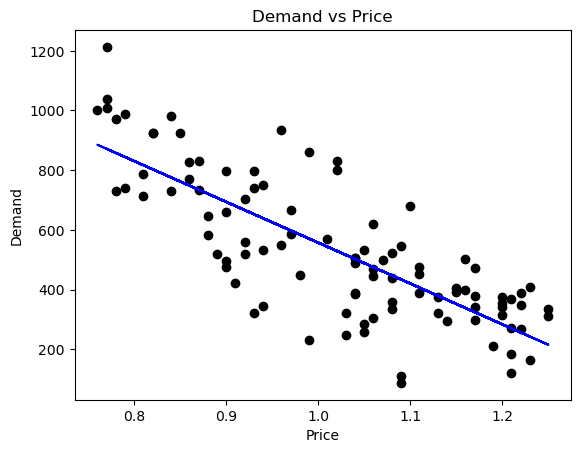

In [6]:
plt.scatter(X, y, color = 'black') 
plt.plot(X, model.predict(X),color='blue') 
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand vs Price')
plt.show()

In [7]:
y = df['residuals'].to_numpy().reshape((-1, 1))
X = df['price'].to_numpy().reshape((-1, 1))
modelres = LinearRegression()
modelres.fit(X, y)

print(f'The line fit is residual = {modelres.coef_[0][0]}*price + {modelres.intercept_[0]}')
df['predicted'] = modelres.predict(X)

The line fit is residual = 4.896377432937519e-13*price + -5.488204393595617e-13


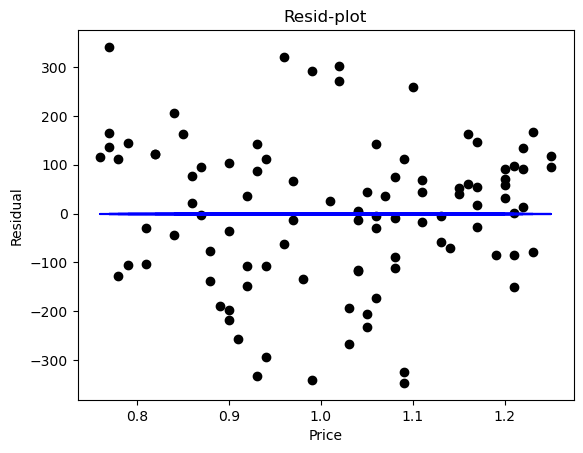

In [8]:
plt.scatter(X, y, color = 'black') 
plt.plot(X, modelres.predict(X),color='blue') 
plt.xlabel('Price')
plt.ylabel('Residual')
plt.title('Resid-plot')
plt.show()

Looking at the plot and the linear regression coefficients of the residuals we can say that the residuals are randomly distributed. Hence, we are going to assume that these residuals are the source of randomness in the data.

## Rush Order and Disposal rates

In addition to the effect of price on demand we are going to consider having the option of rush orders at a higher price in case the quantity we produced is lower than the Demand and the option of disposing of extra newspapers in case we produced more than the demand. We are going to assume the following costs going furthur:

- c = 0.5 (normal cost per newspaper)
- g = 0.75 (rush order cost per newspaper)
- t = 0.15 (disposal cost per newspaper)

Also, initially we are going to assume a selling price of $1, generate the demand based on this price using the linear regression model and residuals to get the optimal quantity to produce before moving onto solving for optimal selling price as well.

In [9]:
p = 1
df['gen_demand'] = p*model.coef_[0][0] + model.intercept_[0] + df['residuals']

In [10]:
df.head()

,price,demand,predicted,residuals,gen_demand
0,1.05,283,-3.470081e-14,-205.619393,351.385626
1,0.86,771,-1.277320e-13,22.515227,579.520247
2,1.21,185,4.364123e-14,-84.785389,472.219630
3,0.94,531,-8.856096e-14,-108.067771,448.937249
4,0.76,1002,-1.766958e-13,116.743975,673.748994


## Linear Programming problem with selling price $1

### Objective

$$\frac{1}{n} \Sigma_{i=1}^{n}s(\beta_0+s\beta_1+\epsilon_i)+h_i $$

Here $h_i$ refers to the negative of cost on day *i*. The whole objective referes to the expected value of profit over the previous days. This objective would have been quadratic had the selling price been a decision variable. But for now we take s as $1. Taking s(selling price) = 1 we get the following:

$$\frac{1}{n} \Sigma_{i=1}^{n}(\beta_0+\beta_1+\epsilon_i)+h_i $$


### Constraints

$$h_i\leq-cq-g(D-q)$$
$$h_i\leq-cq-t(q-D)$$

After rearranging the terms and writing $D_i$ in terms of its price regression equation we get:

$$h_i+(c-g)q\leq-g(\beta_0+\beta_1+\epsilon_i)$$
$$h_i+(c+t)q\leq t(\beta_0+\beta_1+\epsilon_i)$$

In [11]:
c=0.5
g=0.75
t=0.15

beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]

# decision variables are (q, h1, h2, ..., h25)
# q, p, h
# We are ignoring the residuals because they sum to zero
obj = np.array([-c, beta_0] + [1/len(df)]*len(df))
lb = np.array([0, 0] + [-np.inf]*len(df))

# constraints                         
A_1 = np.hstack((np.array([-g]*len(df)).T.reshape((-1, 1)), np.array([g*beta_1]*len(df)).T.reshape((-1, 1)), np.eye(len(df))))
A_2 = np.hstack((np.array([t]*len(df)).T.reshape((-1, 1)), np.array([-t*beta_1]*len(df)).T.reshape((-1, 1)), np.eye(len(df))))
A_3 = np.array([0, 1] + [0]*len(df))
A = np.vstack((A_1, A_2, A_3))

# rhs
rhs = np.concatenate((-g*df['residuals'].to_numpy() - g*beta_0, t*df['residuals'].to_numpy() + t*beta_0, np.array([1])), axis=0)

# sense 
sense = np.array(['<']*2*len(df) + ['='])

In [12]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj), lb=lb, vtype=['I']+['C']*(len(obj)-1)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, sense, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None, obj, beta_1, sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [13]:
decision_vars_lp = spMod_x.x 
profit_lp = spMod.objVal

In [14]:
standard_optqty = decision_vars_lp[0]
standard_optprofit = profit_lp

print(f"""
PROFIT is: \n
{profit_lp} \n
OPTIMAL QUANTITY: \n
{decision_vars_lp[0]} \n
""")


PROFIT is: 

231.48305473619007 

OPTIMAL QUANTITY: 

472.0 




## Quadratic Programming problem to get optimal selling price
### Objective

$$\frac{1}{n} \Sigma_{i=1}^{n}s(\beta_0+s\beta_1+\epsilon_i)+h_i $$

Expanding the equation:

$$\frac{\beta_1}{n}s^2+\frac{\beta_0}{n}s+\Sigma_{i=1}^{n}\frac{\epsilon_i}{n}s+\frac{h_i}{n} $$


### Constraints
The constraints will remain the same as before:

$$h_i+(c-g)q\leq-g(\beta_0+\beta_1+\epsilon_i)$$
$$h_i+(c+t)q\leq t(\beta_0+\beta_1+\epsilon_i)$$

In [15]:
# defining a python function which takes in the linear regression coefficients and the dataset as input
# and gives the optimal price, quantity and expected price as output. This way we can just call this function
# whenever we want to look at the variations of our results

def QP_newsvendor(beta_0, beta_1, df):
    # q, p, h
    # We are ignoring the residuals because they sum to zero
    obj = np.array([-c, beta_0] + [1/len(df)]*len(df))
    lb = np.array([0, 0] + [-np.inf]*len(df))

    # constraints                         
    A_1 = np.hstack((np.array([-g]*len(df)).T.reshape((-1, 1)), np.array([g*beta_1]*len(df)).T.reshape((-1, 1)), np.eye(len(df))))
    A_2 = np.hstack((np.array([t]*len(df)).T.reshape((-1, 1)), np.array([-t*beta_1]*len(df)).T.reshape((-1, 1)), np.eye(len(df))))
    A = np.vstack((A_1, A_2))

    # rhs
    rhs = np.concatenate((-g*df['residuals'].to_numpy() - g*beta_0, t*df['residuals'].to_numpy() + t*beta_0), axis=0)

    # sense 
    sense = np.array(['<']*2*len(df))

    # quadratic term
    Q = np.zeros((len(df) + 2, len(df) + 2))
    Q[1, 1] = beta_1

    # Optimization
    nvMod = gp.Model()
    nvMod_x = nvMod.addMVar(2 + len(df), lb=lb, vtype=['I'] + ['C']*(len(df)+1))
    nvMod_con = nvMod.addMConstrs(A, nvMod_x, sense, rhs)
    nvMod.setMObjective(Q, obj, 0, sense=gp.GRB.MAXIMIZE)

    nvMod.Params.OutputFlag = 0 
    nvMod.optimize()

    return nvMod.objVal, nvMod_x.x

In [16]:
profit, decision_vars = QP_newsvendor(model.intercept_[0], model.coef_[0][0], df)

modified_optqty = decision_vars[0]
modified_optprice = decision_vars[1]
modified_optprofit = profit

print(f"""
PROFIT is: \n
{profit} \n
OPTIMAL QUANTITY: \n
{decision_vars[0]} \n
OPTIMAL PRICE: \n
{decision_vars[1]} \n
""")


PROFIT is: 

234.41170759748593 

OPTIMAL QUANTITY: 

535.0 

OPTIMAL PRICE: 

0.953626496623454 




## Sensitivity of our results to the data

We are now interested to know how sensitive the optimal price and quantity are to our data set. We will first take a bootstrap sample of the original dataset.  Go back and fit new beta’s to the new bootstrapped dataset and find the new optimal price and quantity.

In [17]:
df_copy = df_copy.sample(len(df), replace=True)
df_copy.head()

,price,demand
51,1.21,270
59,0.96,933
93,1.05,532
76,1.06,445
5,0.81,713


In [18]:
y = df_copy['demand'].to_numpy().reshape((-1, 1))
X = df_copy['price'].to_numpy().reshape((-1, 1))
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
print(f'The line fit is demand = {model.coef_[0][0]}*price + {model.intercept_[0]}')
df_copy['predicted'] = model.predict(X)
df_copy['residuals'] = df_copy['demand'] - df_copy['predicted']
profit, decision_vars = QP_newsvendor(model.intercept_[0], model.coef_[0][0], df_copy)

The line fit is demand = -1337.8875352424616*price + 1893.7060194299338


In [20]:
print(f"""
PROFIT is: \n
{profit} \n
OPTIMAL QUANTITY: \n
{decision_vars[0]} \n
OPTIMAL PRICE: \n
{decision_vars[1]} \n
""")


PROFIT is: 

236.32364046155226 

OPTIMAL QUANTITY: 

515.0 

OPTIMAL PRICE: 

0.9577224241747445 




## Bootstrapping multiple data samples

We are going to repeat the above process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. This is going to give us a distribution of optimal quantities, prices and expected profits.

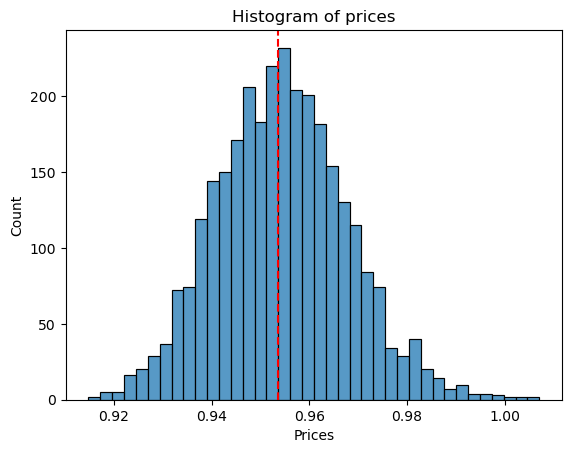

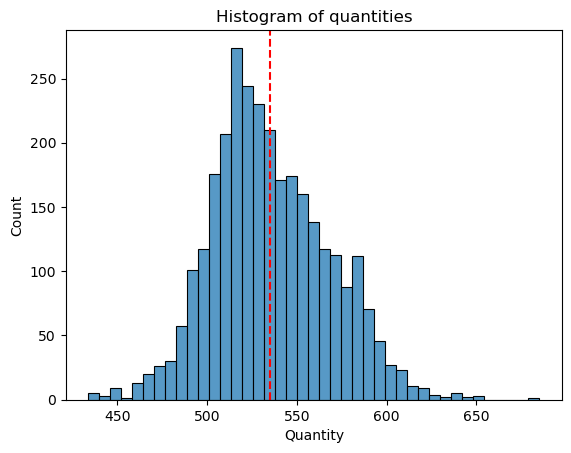

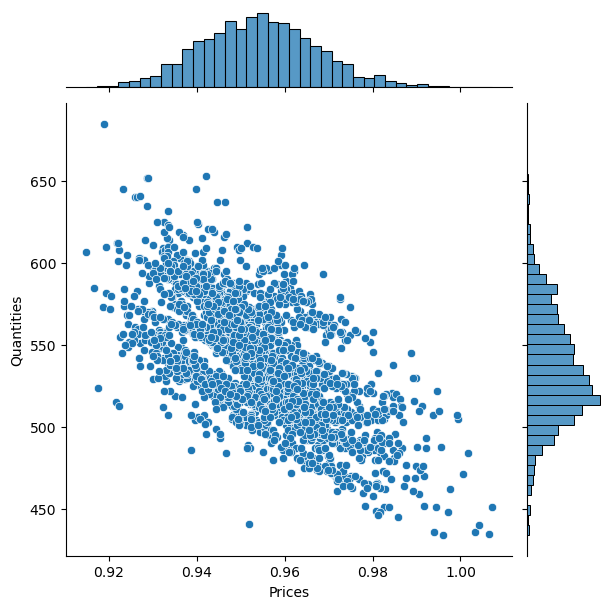

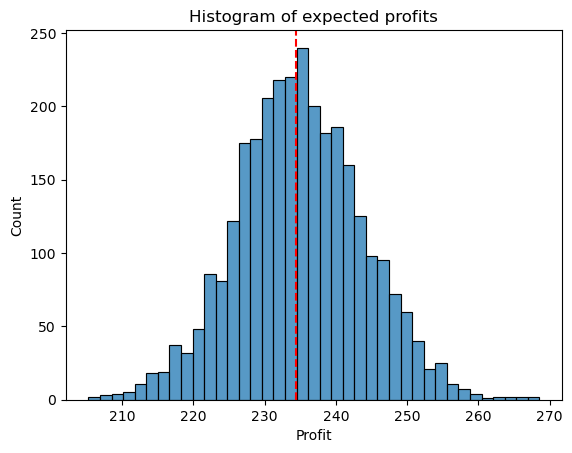

In [28]:
df = pd.read_csv('price_demand_data.csv')
prices = []
quantities = []
profits = []
for i in range(3000):
    df_copy = copy.deepcopy(df)
    df_copy = df_copy.sample(len(df), replace=True)
    y = df_copy['demand'].to_numpy().reshape((-1, 1))
    X = df_copy['price'].to_numpy().reshape((-1, 1))
    model = LinearRegression()
    model.fit(X, y)
    df_copy['predicted'] = model.predict(X)
    df_copy['residuals'] = df_copy['demand'] - df_copy['predicted']
    profit, decision_vars = QP_newsvendor(model.intercept_[0], model.coef_[0][0], df_copy)
    prices.append(decision_vars[1])
    quantities.append(decision_vars[0])
    profits.append(profit)
 


 # histplots
sns.histplot(prices)
plt.xlabel('Prices')
plt.title('Histogram of prices')
plt.axvline(x=modified_optprice, color='r', linestyle='--')
plt.show()
sns.histplot(quantities)
plt.xlabel('Quantity')
plt.title('Histogram of quantities')
plt.axvline(x=modified_optqty, color='r', linestyle='--')
plt.show()

# joint plot
h=sns.jointplot(x=prices, y=quantities)
h.ax_joint.set_xlabel('Prices')
h.ax_joint.set_ylabel('Quantities')
plt.show()

# expectation of profits
sns.histplot(profits)
plt.xlabel('Profit')
plt.title('Histogram of expected profits')
plt.axvline(x=modified_optprofit, color='r', linestyle='--')
plt.show()

In [22]:
def mean_confidence_interval(data):
    return sms.DescrStatsW(data).tconfint_mean()
    
profit_conf = mean_confidence_interval(profits)
quantity_conf = mean_confidence_interval(quantities)
prices_conf = mean_confidence_interval(prices)


str = ['expected profit', 'quantity', 'prices']
for s, i in zip(str, [profit_conf, quantity_conf, prices_conf]): 
    print(f"95% Confidence interval for {s} is {i}")

95% Confidence interval for expected profit is (234.82704139897484, 235.47573306452475)
95% Confidence interval for quantity is (534.2648226246823, 536.665177376006)
95% Confidence interval for prices is (0.954065740651004, 0.9550459067062167)


## Comparing the optimal quantities and expected profits from various Newsvendor models

### Basic Newsvendor Problem without rush orders and disposal and varying selling price

#### Objective

$$\frac{1}{n}\Sigma h_i$$

Here $h_i$ refers to the profit on day *i*. We changed the representation of $h_i$ from cost to profit to simplify the math. If we had taken $h_i$ as profit in the previous models we wouldn't have gotten linear constraints in those programs. Also, here we are not considering effect of selling price on demand

#### Constraints

$$h_i\leq s_iD_i - cq$$
$$h_i\leq s_iq - cq$$

By rearranging the terms, we get:

$$h_i+cq\leq s_iD_i$$
$$h_i+(c-s)q\leq0$$

In [23]:
# python code for basic Newsvendor problem
rows = len(df)
obj = np.zeros(1+rows)
obj[1:] = 1
A = np.zeros((rows*2,1+rows))
for i in range(rows):
    A[i,0] = c-df.iloc[i][0]
    A[i,i+1] = 1

    A[rows+i,0] = c
    A[rows+i,i+1] = 1


b = np.zeros(rows*2)
b[rows:] = df['price']*df['demand']
sense = np.array(['<']*rows*2)
lb = np.array([0]+[-np.inf]*rows)
vtype = np.array(['I']+['C']*rows)

Model = gp.Model()
Model_x = Model.addMVar(1+rows, lb=lb, vtype=vtype)
Model_con = Model.addMConstrs(A, Model_x, sense, b)
Model.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

Model.Params.OutputFlag = 0 
Model.optimize()
basicnvp_optqty = Model_x.x[0]
basicnvp_optprofit = Model.objVal/99

### Newsvendor problem with rush order and disposal and varying selling price

#### Objective

$$\frac{1}{n}\Sigma h_i$$

#### Constraints

Due to considering the option of having rush orders and disposal we are going to sell the full demand each day and adjust our profits by varying our costs based on whether the optimal quantity is higher or lower than the demand.

$$h_i\leq s_iD_i-cq- g(D_i-q)$$
$$h_i\leq s_iD_i-cq-t(q-D_i)$$

By rearranging the terms, we get:

$$h_i+(c-g)q\leq (s_i-g)D_i$$
$$h_i+(c+t)q\leq(s_i+t)D_i$$

In [24]:
# python code for Newsvendor problem with rush and disposal options
rows = len(df)
obj = np.zeros(1+rows)
obj[1:] = 1
A = np.zeros((rows*2,1+rows))
for i in range(rows):
    A[i,0] = c-g
    A[i,i+1] = 1

    A[rows+i,0] = c+t
    A[rows+i,i+1] = 1


b = np.zeros(rows*2)
b[:rows] = (df['price']-g)*df['demand']
b[rows:] = (df['price']+t)*df['demand']
sense = np.array(['<']*rows*2)
lb = np.array([0]+[-np.inf]*rows)
vtype = np.array(['I']+['C']*rows)

Model = gp.Model()
Model_x = Model.addMVar(1+rows, lb=lb, vtype=vtype)
Model_con = Model.addMConstrs(A, Model_x, sense, b)
Model.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

Model.Params.OutputFlag = 0 
Model.optimize()
rush_disp_nvp_optqty = Model_x.x[0]
rush_disp_nvp_optprofit = Model.objVal/99

In [25]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

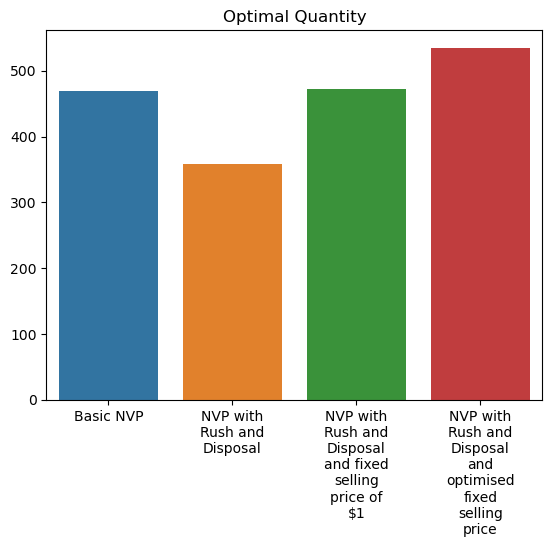

In [26]:
ax = sns.barplot(x=['Basic NVP', 'NVP with Rush and Disposal','NVP with Rush and Disposal and fixed selling price of $1',\
         'NVP with Rush and Disposal and optimised fixed selling price'],\
            y=[basicnvp_optqty, rush_disp_nvp_optqty, standard_optqty, modified_optqty])

ax.set_title('Optimal Quantity')
wrap_labels(ax, 10)
ax.figure
plt.show()

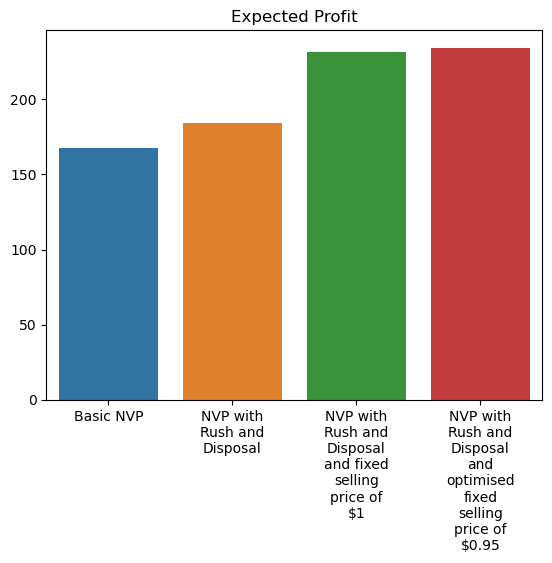

In [27]:
ax = sns.barplot(x=['Basic NVP', 'NVP with Rush and Disposal','NVP with Rush and Disposal and fixed selling price of $1',\
         'NVP with Rush and Disposal and optimised fixed selling price of $0.95'],\
            y=[basicnvp_optprofit, rush_disp_nvp_optprofit, standard_optprofit, modified_optprofit])

ax.set_title('Expected Profit')
wrap_labels(ax, 10)
ax.figure
plt.show()

As we increase the model complexity, we are taking into account multiple factors from the real world which is also increasing the flexibility of what we can do based on the situation on each day. This flexibility leads to a higher expected profit.